In [1]:
import os
import pandas as pd
import numpy as np
import cv2 as opencv
import matplotlib.pyplot as plt

In [2]:
!unzip '/content/skin type dataset.zip'

Archive:  /content/skin type dataset.zip
   creating: skin type dataset/
   creating: skin type dataset/dry/
  inflating: skin type dataset/dry/1 (502).tif  
  inflating: skin type dataset/dry/1 (509).tif  
  inflating: skin type dataset/dry/1 (510).tif  
  inflating: skin type dataset/dry/1 (513).tif  
  inflating: skin type dataset/dry/1 (518).tif  
  inflating: skin type dataset/dry/1 (519).tif  
  inflating: skin type dataset/dry/1 (520).tif  
  inflating: skin type dataset/dry/1 (540).tif  
  inflating: skin type dataset/dry/1 (543).tif  
  inflating: skin type dataset/dry/1 (552).tif  
  inflating: skin type dataset/dry/1 (553).tif  
  inflating: skin type dataset/dry/1 (565).tif  
  inflating: skin type dataset/dry/1 (568).tif  
  inflating: skin type dataset/dry/1 (569).tif  
  inflating: skin type dataset/dry/1 (593).tif  
  inflating: skin type dataset/dry/1 (599).tif  
  inflating: skin type dataset/dry/1 (600).tif  
  inflating: skin type dataset/dry/1 (601).tif  
  inflati

In [3]:
path = '/content/skin type dataset/'
classes = sorted(os.listdir(path))
classes = np.array(classes)

In [4]:
from sklearn import preprocessing
from keras.utils import to_categorical

label_encoder = preprocessing.LabelEncoder()
labels = label_encoder.fit_transform(classes)

In [5]:
labels_classes_array = np.stack((labels,classes),axis=1)
classes_dictionary = {y:int(x) for x,y in labels_classes_array}
print('Classes Array ==> ',labels_classes_array)
print()
print('Classes Dictionary ==> ',classes_dictionary)

Classes Array ==>  [['0' 'dry']
 ['1' 'normal']
 ['2' 'oily']
 ['3' 'sensitive']]

Classes Dictionary ==>  {'dry': 0, 'normal': 1, 'oily': 2, 'sensitive': 3}


In [6]:
labels_dataFrame = pd.DataFrame(labels_classes_array,columns=[['labels','classes']])
print(labels_dataFrame)

  labels    classes
0      0        dry
1      1     normal
2      2       oily
3      3  sensitive


In [7]:
labels_dataFrame.to_csv('/content/classes.csv',index=False)

In [8]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

In [25]:
def image_preprocessing(image:np.array):
  image = opencv.resize(image,(150,150))
  image = opencv.cvtColor(image, opencv.COLOR_BGR2RGB)

  #NORMALIZATION of image
  # image = scaler.fit_transform(image.reshape(-1, image.shape[-1])).reshape(image.shape)
  image = image/255
  return image
  pass

In [26]:
def load_dataset(dataset_folder_path,classes_dictionary):

  skin_dataset_list = []
  classes_folders = sorted(os.listdir(dataset_folder_path))

  for folder in classes_folders:
    label = classes_dictionary[folder] # Label of corresponding class name i.e ['0' 'dry'] ['3' 'sensitive']
    folder_path = os.path.join(dataset_folder_path,folder)
    images_names_list = os.listdir(folder_path)
    for image_name in images_names_list:
      image_path = os.path.join(folder_path,image_name)
      image = opencv.imread(image_path)
      image = image_preprocessing(image)
      one_hot_encoded_label = to_categorical(label,num_classes=4)
      skin_dataset_list.append([one_hot_encoded_label,image])
      pass
    pass
  return np.asarray(skin_dataset_list, dtype="object")
  pass

In [27]:
skin_dataset_array = load_dataset(path,classes_dictionary)

In [28]:
print(skin_dataset_array.shape)

(178, 2)


In [29]:
#plot random images
def show_skin_images_samples(skin_dataset_array):
  n = 6
  samples = np.random.choice(skin_dataset_array.shape[0], n, replace=False)
  fig = plt.figure(figsize= (14, 9))
  for idx,sample in enumerate(samples):
    ax = fig.add_subplot(2, 3, idx+1)
    label = np.argmax(skin_dataset_array[sample,0],axis=0)
    ax.title.set_text(list(classes_dictionary.keys())[list(classes_dictionary.values()).index(label)])
    ax.axis('off')
    ax.imshow((skin_dataset_array[sample,1] * 255).astype(np.uint8))
    pass
  pass

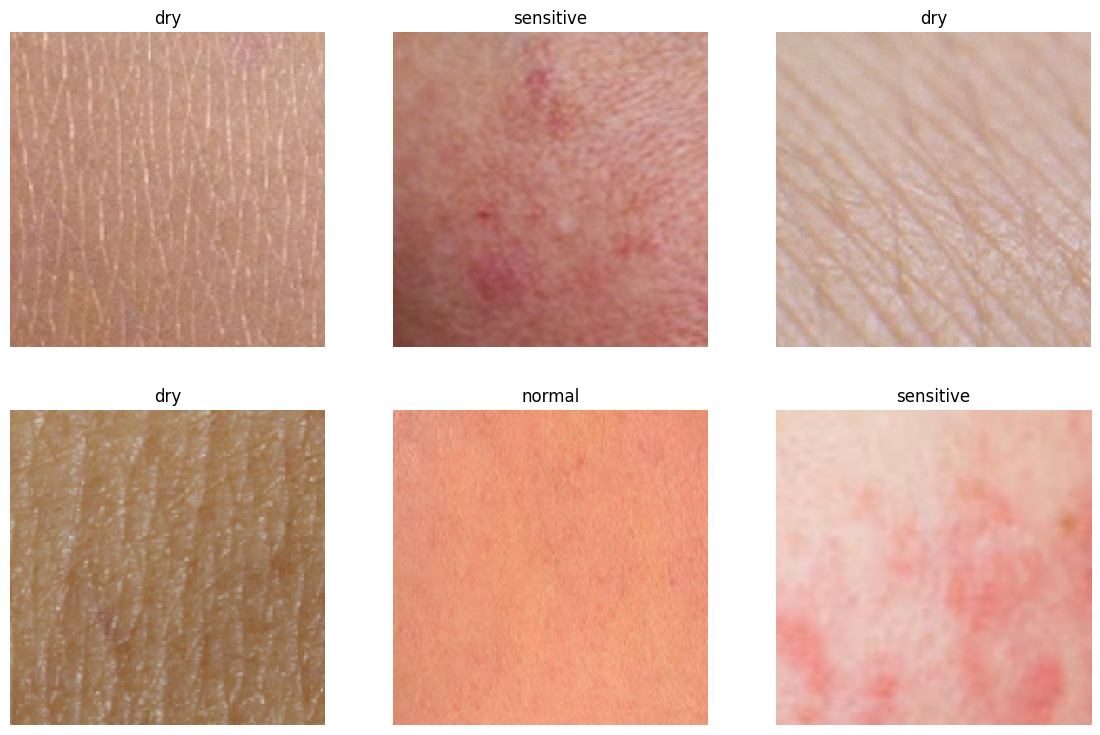

In [30]:
show_skin_images_samples(skin_dataset_array)

In [31]:
import keras
from keras.layers import Flatten, Dense, Dropout
from keras.models import Sequential

from keras.optimizers import Adam

In [39]:
base_model = keras.applications.VGG16(
    include_top=False,
    weights="imagenet",
    input_shape=(150,150,3),
    pooling="max",
    classes=4,
)

for layer in base_model.layers:
        layer.trainable=False

VGG16_model = Sequential()

VGG16_model.add(base_model)
VGG16_model.add(Flatten())
VGG16_model.add(Dense(256, activation='relu', kernel_initializer='he_uniform'))
VGG16_model.add(Dropout(0.2))
VGG16_model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
VGG16_model.add(Dropout(0.2))
VGG16_model.add(Dense(64, activation='relu', kernel_initializer='he_uniform'))
VGG16_model.add(Dropout(0.1))
VGG16_model.add(Dense(32, activation='relu', kernel_initializer='he_uniform'))
VGG16_model.add(Dense(16, activation='relu', kernel_initializer='he_uniform'))
VGG16_model.add(Dense(4, activation='softmax'))

print(VGG16_model.summary())

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 512)               14714688  
                                                                 
 flatten_4 (Flatten)         (None, 512)               0         
                                                                 
 dense_21 (Dense)            (None, 256)               131328    
                                                                 
 dropout_11 (Dropout)        (None, 256)               0         
                                                                 
 dense_22 (Dense)            (None, 128)               32896     
                                                                 
 dropout_12 (Dropout)        (None, 128)               0         
                                                                 
 dense_23 (Dense)            (None, 64)               

In [40]:
learning_method = Adam(learning_rate=0.001)
VGG16_model.compile(optimizer=learning_method,loss='categorical_crossentropy',metrics=['accuracy'])

In [41]:
X = np.array(skin_dataset_array[:,1].tolist())
Y = np.array(skin_dataset_array[:,0].tolist())

early_stopping_callback = keras.callbacks.EarlyStopping(monitor='loss',patience=12)

VGG16_history = VGG16_model.fit(X,Y,
                                batch_size=16,
                                callbacks=[early_stopping_callback],
                                epochs=100,
                                steps_per_epoch=int(len(skin_dataset_array)/16))


VGG16_model.save('/content/skin_recognition_model.hdf5')

Epoch 1/100
11/11 [==============================] - 3s 46ms/step - loss: 1.4495 - accuracy: 0.2102
Epoch 2/100
11/11 [==============================] - 0s 40ms/step - loss: 1.3930 - accuracy: 0.2407
Epoch 3/100
11/11 [==============================] - 0s 36ms/step - loss: 1.2924 - accuracy: 0.3457
Epoch 4/100
11/11 [==============================] - 0s 37ms/step - loss: 1.2113 - accuracy: 0.4815
Epoch 5/100
11/11 [==============================] - 0s 37ms/step - loss: 1.1382 - accuracy: 0.5309
Epoch 6/100
11/11 [==============================] - 0s 36ms/step - loss: 1.0810 - accuracy: 0.5309
Epoch 7/100
11/11 [==============================] - 0s 37ms/step - loss: 0.9535 - accuracy: 0.6420
Epoch 8/100
11/11 [==============================] - 0s 37ms/step - loss: 0.7870 - accuracy: 0.6852
Epoch 9/100
11/11 [==============================] - 0s 38ms/step - loss: 0.9179 - accuracy: 0.6605
Epoch 10/100
11/11 [==============================] - 0s 38ms/step - loss: 0.8345 - accuracy: 0.6852

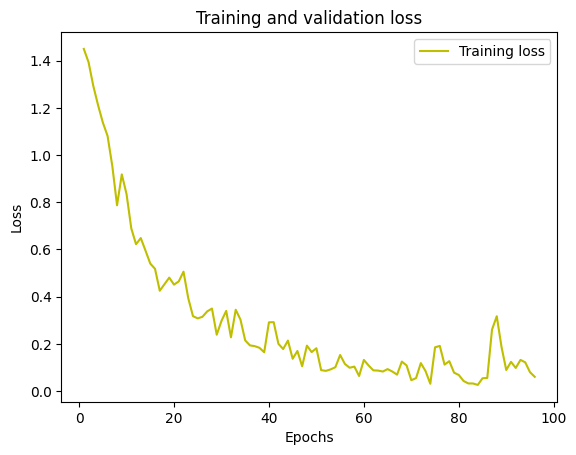

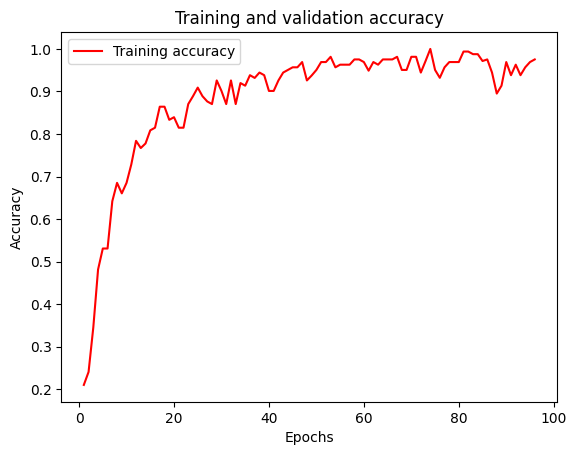

In [42]:
#plot the training and validation IoU and loss at each epoch
loss = VGG16_history.history['loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = VGG16_history.history['accuracy']
plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()